# Modelling

## 1: Import Libraries & Load Data
Mengimpor library machine learning dan memuat data training/validation yang sudah diproses dari file numpy.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import joblib

print("Libraries imported successfully")

# Load preprocessed data
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
label_encoder = joblib.load('label_encoder.pkl')

print(f"Training data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Classes: {label_encoder.classes_}")

Libraries imported successfully
Training data: (300, 28)
Validation data: (100, 28)
Classes: ['buka' 'tutup']



## 2: Train Random Forest Model
Membuat model Random Forest dengan 100 trees dan max depth 10, kemudian melatihnya menggunakan data training.


In [8]:
print("Training Random Forest Model")
print("=" * 40)

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

print("Model training completed")
print(f"Number of trees: {len(rf_model.estimators_)}")

Training Random Forest Model
Model training completed
Number of trees: 100



## 3: Model Evaluation
Menghitung akurasi model pada data training dan validation, serta melakukan cross-validation untuk menguji konsistensi performa.


In [9]:
print("Model Evaluation")
print("=" * 40)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Model Evaluation
Training Accuracy: 1.0000
Validation Accuracy: 1.0000
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000 (+/- 0.0000)



## 4: Visualisasi Performance
Menampilkan confusion matrix untuk melihat distribusi prediksi dan grafik perbandingan akurasi training vs validation.


Performance Visualization


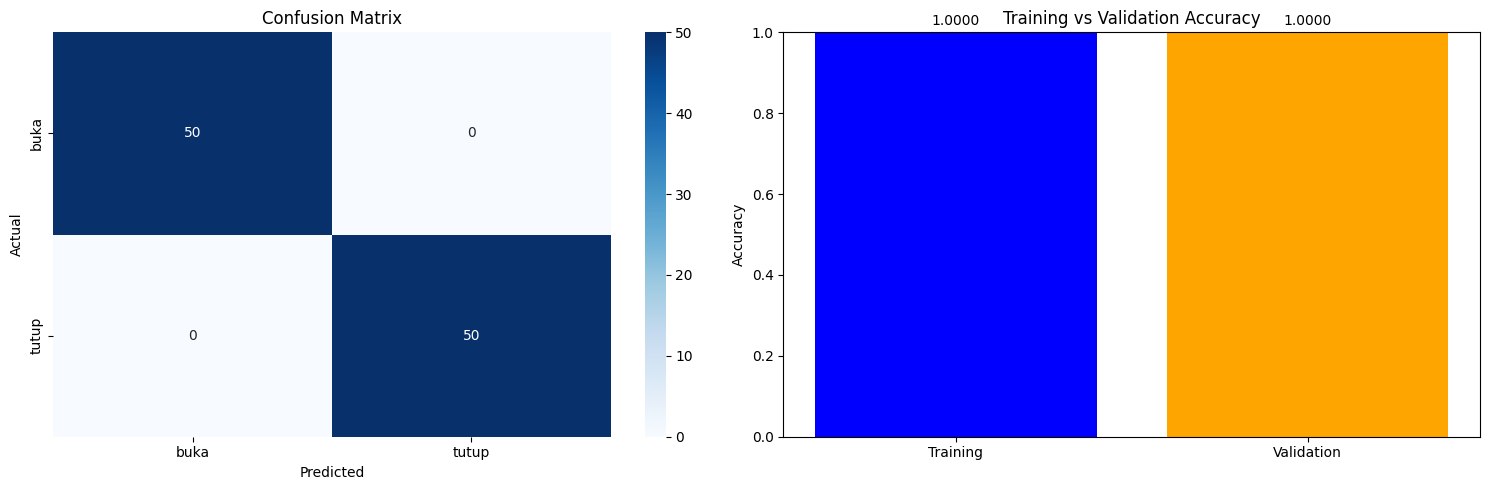

In [10]:
print("Performance Visualization")
print("=" * 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Accuracy Comparison
accuracies = [train_accuracy, val_accuracy]
labels = ['Training', 'Validation']
bars = ax2.bar(labels, accuracies, color=['blue', 'orange'])
ax2.set_title('Training vs Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 5: Feature Importance Analysis
Menganalisis dan memvisualisasikan 15 fitur paling penting yang mempengaruhi keputusan model dalam klasifikasi.


Feature Importance Analysis


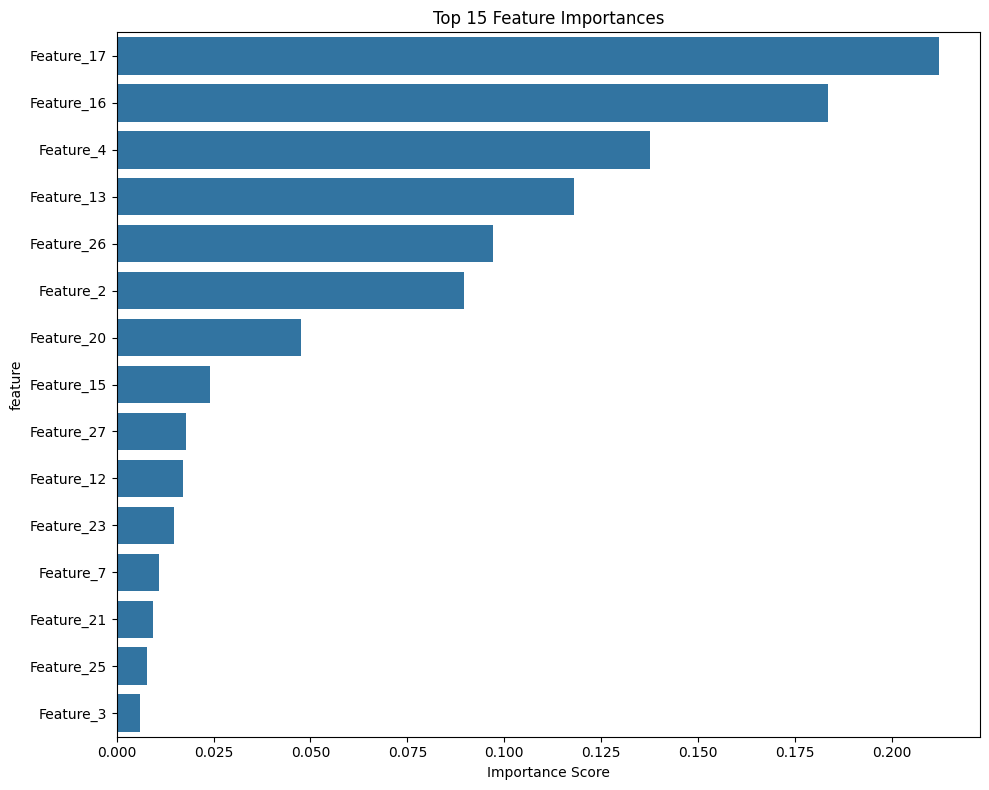

Top 10 most important features:
      feature  importance
0  Feature_17    0.212159
1  Feature_16    0.183553
2   Feature_4    0.137599
3  Feature_13    0.118026
4  Feature_26    0.097122
5   Feature_2    0.089644
6  Feature_20    0.047642
7  Feature_15    0.024142
8  Feature_27    0.017980
9  Feature_12    0.017080


In [11]:
print("Feature Importance Analysis")
print("=" * 40)

# Get feature importance
feature_importance = rf_model.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(importance_df.head(10).reset_index(drop=True))


## 6: Detailed Classification Report
Menampilkan laporan klasifikasi detail termasuk precision, recall, dan F1-score untuk setiap kelas.


In [12]:
print("Detailed Classification Report")
print("=" * 40)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred, 
                          target_names=label_encoder.classes_))

# Calculate class-wise accuracy
class_report = classification_report(y_val, y_val_pred, 
                                   target_names=label_encoder.classes_, 
                                   output_dict=True)

print("\nKey Metrics:")
for class_name in label_encoder.classes_:
    precision = class_report[class_name]['precision']
    recall = class_report[class_name]['recall']
    f1 = class_report[class_name]['f1-score']
    print(f"{class_name}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

Detailed Classification Report
Validation Set Performance:
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        50
       tutup       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Key Metrics:
buka: Precision=1.0000, Recall=1.0000, F1-score=1.0000
tutup: Precision=1.0000, Recall=1.0000, F1-score=1.0000



## 7: Save Model
Menyimpan model yang sudah dilatih ke file pickle untuk digunakan pada tahap deployment atau inferensi.

In [13]:
print("Saving Model")
print("=" * 40)

# Save the trained model
joblib.dump(rf_model, 'random_forest_model.pkl')

print("Model saved as 'random_forest_model.pkl'")
print("Model training and evaluation completed successfully")

# Final summary
print("\nModel Training Summary:")
print(f"Best Validation Accuracy: {val_accuracy:.4f}")
print(f"Feature Space: {X_train.shape[1]} features")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Validation Samples: {X_val.shape[0]}")
print(f"Classes: {list(label_encoder.classes_)}")

Saving Model
Model saved as 'random_forest_model.pkl'
Model training and evaluation completed successfully

Model Training Summary:
Best Validation Accuracy: 1.0000
Feature Space: 28 features
Training Samples: 300
Validation Samples: 100
Classes: ['buka', 'tutup']


# **[Link Deploy Prediksi NO2 Medan](https://prediksi-no2-kotamedan.streamlit.app//)**